In [60]:
%pip install matplotlib ipywidgets

You should consider upgrading via the '/home/js1044k/FastMRI/FastMRI_2024_shasha/venv/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [61]:
import os
from dotenv import load_dotenv
import h5py
import numpy as np
from matplotlib import pyplot as plt, gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']
result_dir_path = os.environ['RESULT_DIR_PATH']

## Recon Visualization

In [62]:
def show_image_with_recon(img_name, slice_idx=0, cmap='gray'):
    img_path = f'{data_dir_path}/leaderboard/acc5/image/{img_name}'
    public_recon_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard/public/{img_name}'
    private_recon_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard/private/{img_name}'

    img_keys = ['image_label']
    recon_key = 'reconstruction'
    img_title = img_path.split('/')[-1]
    
    # show image
    hf = h5py.File(img_path)
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'{img_title} - slice {slice_idx}')
    for j, key in enumerate(img_keys):
        ax = plt.subplot(1, len(img_keys) + 2, j + 1)
        img_slice = hf[key][slice_idx]
        plt.title(key)
        ax.imshow(img_slice, cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    # show recon
    hf = h5py.File(public_recon_path, 'r')
    ax = plt.subplot(1, len(img_keys) + 2, len(img_keys) + 1)
    recon_slice = hf[recon_key][slice_idx]
    plt.title('public')
    ax.imshow(recon_slice, cmap=cmap)
    plt.axis('off')
    
    # show recon
    hf = h5py.File(private_recon_path, 'r')
    ax = plt.subplot(1, len(img_keys) + 2, len(img_keys) + 2)
    recon_slice = hf[recon_key][slice_idx]
    plt.title('private')
    ax.imshow(recon_slice, cmap=cmap)
    plt.axis('off')
    
    plt.show()

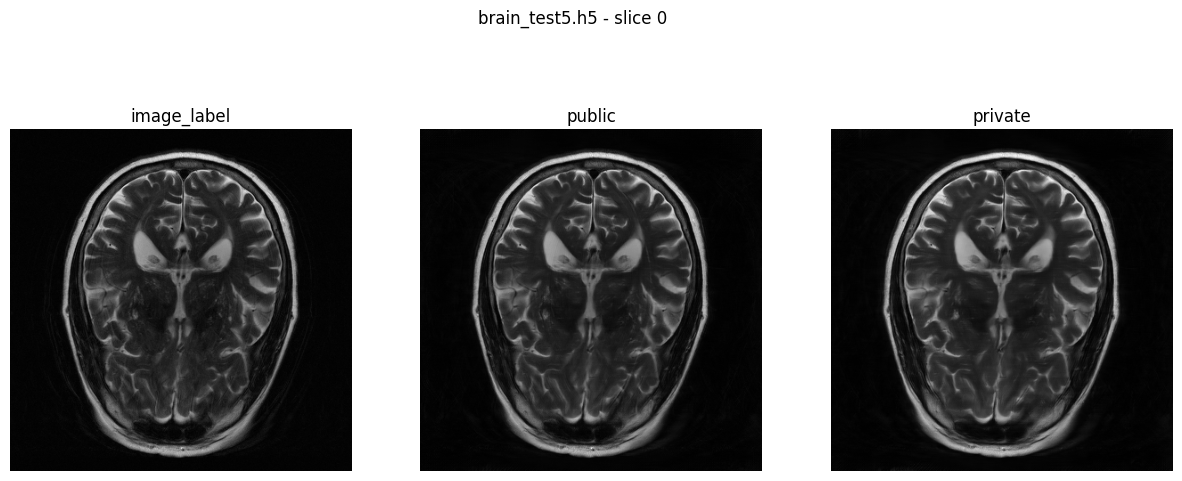

In [63]:
show_image_with_recon('brain_test5.h5')

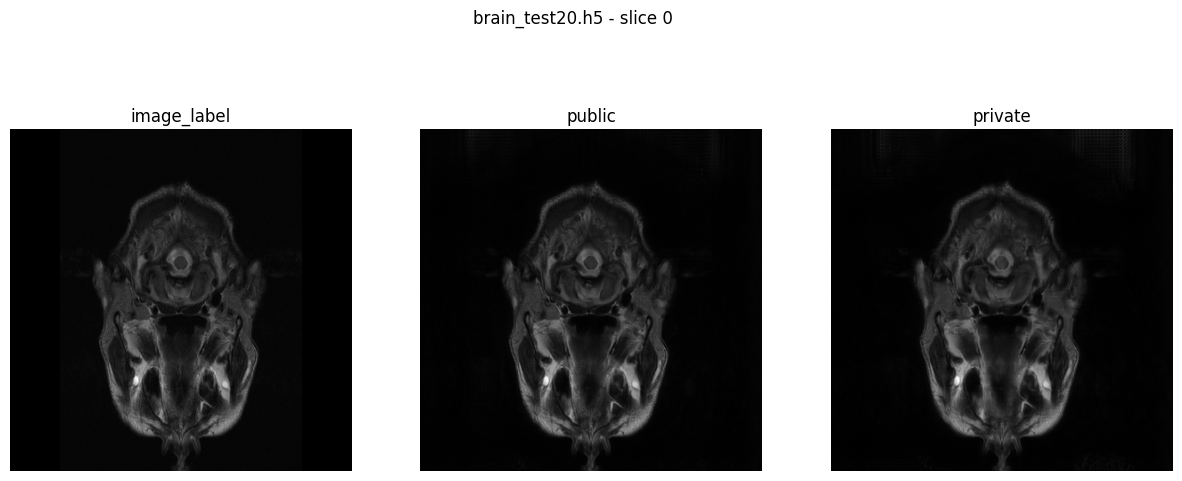

In [64]:
show_image_with_recon('brain_test20.h5')

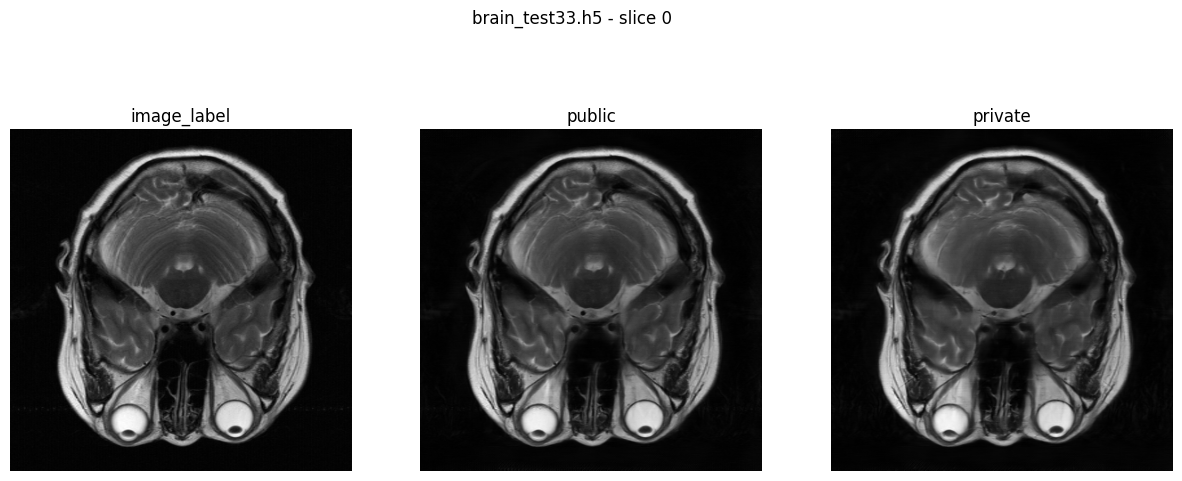

In [65]:
show_image_with_recon('brain_test33.h5')

## Error Map

In [168]:
import torch
from leaderboard_eval import SSIM
from skimage.metrics import structural_similarity as ssim
import cv2

ssim_calc = SSIM()

def show_error_map(img_name, slice_idx=0, cmap=None, show=False):
    img_path = f'{data_dir_path}/leaderboard/acc5/image/{img_name}'
    public_recon_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard/public/{img_name}'
    private_recon_path = f'{result_dir_path}/test_Varnet/reconstructions_leaderboard/private/{img_name}'
    
    label_key = 'image_label'
    recon_key = 'reconstruction'
    img_title = img_path.split('/')[-1]
    
    # fetch label
    hf = h5py.File(img_path)
    if len(hf[label_key]) <= slice_idx:
        return (None, None)

    label_slice = hf[label_key][slice_idx]
    maximum = hf.attrs['max']
    
    # get mask
    mask = np.zeros(label_slice.shape)
    mask[label_slice > 5e-5] = 1
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=15)
    mask = cv2.erode(mask, kernel, iterations=14)
    
    # fetch public recon
    hf = h5py.File(public_recon_path)
    public_recon_slice = hf[recon_key][slice_idx]
    
    # fetch private recon
    hf = h5py.File(private_recon_path)
    private_recon_slice = hf[recon_key][slice_idx]
    
    # apply mask
    label_slice = label_slice * mask
    public_recon_slice = public_recon_slice * mask
    private_recon_slice = private_recon_slice * mask

    (public_ssim_score, public_error_slice) = ssim(label_slice, public_recon_slice, data_range=maximum, full=True)
    (private_ssim_score, private_error_slice) = ssim(label_slice, private_recon_slice, data_range=maximum, full=True)
    
    if show:
        fig = plt.figure(figsize=(15, 6))
        plt.suptitle(f'{img_title} - slice {slice_idx}')
        
        ax = plt.subplot(1, 2, 1)
        plt.title(f'public (SSIM: {public_ssim_score:.4f})')
        img1 = ax.imshow(public_error_slice, cmap=cmap, vmin=0.0, vmax=1)
        plt.axis('off')
        plt.colorbar(img1, ax=ax)
        
        ax = plt.subplot(1, 2, 2)
        plt.title(f'private (SSIM: {private_ssim_score:.4f})')
        img2 = ax.imshow(private_error_slice, cmap=cmap, vmin=0.0, vmax=1)
        plt.axis('off')
        plt.colorbar(img2, ax=ax)
    
    return (public_ssim_score, private_ssim_score)

(0.9678899744376255, 0.9346458773342042)

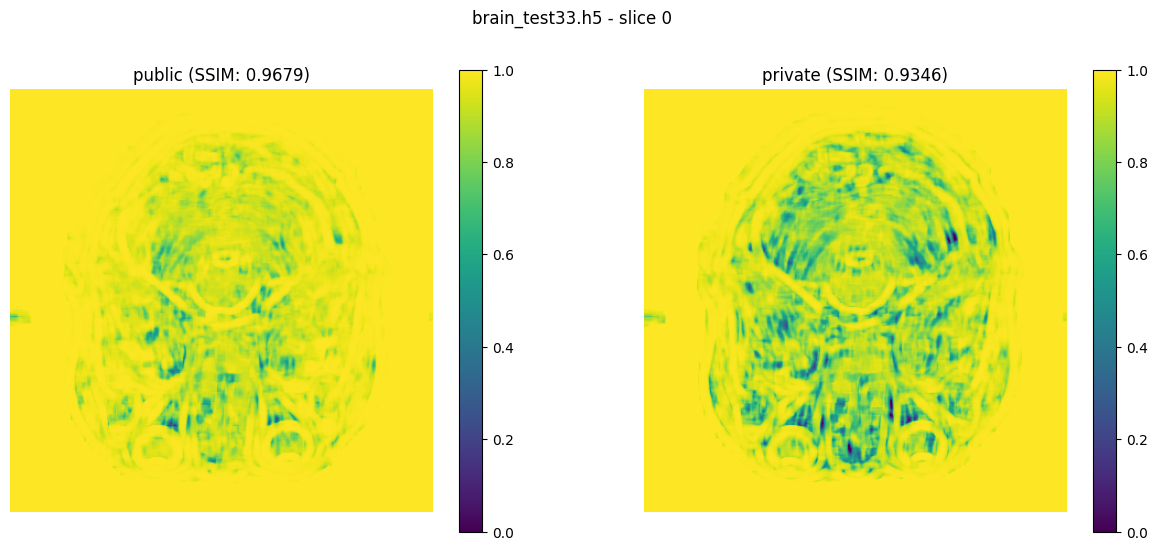

In [169]:
show_error_map(f'brain_test33.h5', show=True)

In [77]:
ssim_df = []
for slice_idx in range(1, 23):
    public_ssim_list = []
    private_ssim_list = []
    for i in range(1, 59):
        public_ssim, private_ssim = show_error_map(f'brain_test{i}.h5', slice_idx=slice_idx)
        public_ssim_list.append(public_ssim)
        private_ssim_list.append(private_ssim)
    ssim_df.append([public_ssim_list, private_ssim_list])

In [78]:
high=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 28, 29]
middle=[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
low=[17, 18, 19, 29, 21, 23, 24, 25, 26, 27]

In [79]:
def plot_histogram(slice_idx=0):
    high_public = [ssim_df[slice_idx][0][i-1] for i in high]
    middle_public = [ssim_df[slice_idx][0][i-1] for i in middle]
    low_public = [ssim_df[slice_idx][0][i-1] for i in low]

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle("Distribution of SSIM score according to sliced position")

    sns.histplot(ax=axes[0], data=high_public, label="high(brain)", binrange=(0.95, 1.0))
    sns.histplot(ax=axes[0], data=middle_public, label="middle(eyes)", binrange=(0.95, 1.0))
    sns.histplot(ax=axes[0], data=low_public, label="low(lower part of face)", binrange=(0.95, 1.0))

    axes[0].set_title("Public(acc5)")
    axes[0].legend()

    high_private = [ssim_df[slice_idx][1][i-1] for i in high]
    middle_private = [ssim_df[slice_idx][1][i-1] for i in middle]
    low_private = [ssim_df[slice_idx][1][i-1] for i in low]

    sns.histplot(ax=axes[1], data=high_private, label="high(brain)", binrange=(0.90, 1.0))
    sns.histplot(ax=axes[1], data=middle_private, label="middle(eyes)", binrange=(0.90, 1.0))
    sns.histplot(ax=axes[1], data=low_private, label="low(lower part of face)", binrange=(0.90, 1.0))

    axes[1].set_title("Private(acc9)")
    axes[1].legend()

In [80]:
slice_idx_slider = widgets.IntSlider(value=0, min=0, max=21, step=1, description='slice_idx')
widgets.interactive(plot_histogram, slice_idx=slice_idx_slider)

interactive(children=(IntSlider(value=0, description='slice_idx', max=21), Output()), _dom_classes=('widget-in…

In [72]:
display(slice_idx_slider)

IntSlider(value=0, description='slice_idx', max=21)

In [ ]:
np.average(public_ssim_list)

In [ ]:
np.average(private_ssim_list)